## pipeline 

In [9]:
import os
import subprocess
import nibabel as nib
import numpy as np
import time

os.environ['FSLDIR'] = '/home/minyoungxi/fsl'
os.environ['PATH'] += os.pathsep + os.path.join(os.environ['FSLDIR'], 'bin')

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/func2/NIFTI/sub-OAS30016_ses-d0021_task-rest_run-02_bold.nii.gz'
t1_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/anat2/NIFTI/sub-OAS30016_ses-d0021_T1w.nii.gz'
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz')
output_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

os.makedirs(output_dir, exist_ok=True)

print("Starting MCFLIRT motion correction...")
start_time = time.time()
mcflirt_output = os.path.join(output_dir, "mcflirt_output")
mcflirt_command = f"mcflirt -in {fmri_file} -out {mcflirt_output} -plots"
subprocess.run(mcflirt_command, shell=True, check=True)
print(f"MCFLIRT motion correction completed in {time.time() - start_time:.2f} seconds")

fmri_file = f"{mcflirt_output}.nii.gz"

fmri_img = nib.load(fmri_file)
fmri_data = fmri_img.get_fdata()

bet_output = os.path.join(output_dir, "bet_output")
bet_command = f"bet {fmri_file} {bet_output} -F -f 0.5 -m"
subprocess.run(bet_command, shell=True, check=True)

mask_img = nib.load(f"{bet_output}_mask.nii.gz")
mask_data = mask_img.get_fdata()
masked_fmri_data = fmri_data * mask_data[..., np.newaxis]
masked_fmri_img = nib.Nifti1Image(masked_fmri_data, fmri_img.affine, fmri_img.header)
masked_fmri_path = os.path.join(output_dir, "masked_fmri.nii.gz")
nib.save(masked_fmri_img, masked_fmri_path)

print("Starting FLIRT registration...")
start_time = time.time()
first_volume = nib.Nifti1Image(masked_fmri_data[..., 0], fmri_img.affine, fmri_img.header)
first_volume_path = os.path.join(output_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_path)

flirt_mat_output = os.path.join(output_dir, "func_to_struct.mat")
flirt_command = f"flirt -in {first_volume_path} -ref {t1_file} -omat {flirt_mat_output} -cost corratio -dof 6"
subprocess.run(flirt_command, shell=True, check=True)

flirt_output = os.path.join(output_dir, "func_to_struct")
apply_xfm_command = f"applywarp --in={masked_fmri_path} --ref={t1_file} --premat={flirt_mat_output} --out={flirt_output}"
subprocess.run(apply_xfm_command, shell=True, check=True)
print(f"FLIRT registration and application completed in {time.time() - start_time:.2f} seconds")

print("Starting FNIRT registration...")
start_time = time.time()
fnirt_output = os.path.join(output_dir, "func_to_mni")
fnirt_command = f"fnirt --in={t1_file} --ref={mni_template} --aff={flirt_mat_output} --cout={fnirt_output}_warp"
subprocess.run(fnirt_command, shell=True, check=True)
print(f"FNIRT registration completed in {time.time() - start_time:.2f} seconds")

print("Applying warp to fMRI data...")
start_time = time.time()
apply_warp_command = f"applywarp --in={flirt_output} --ref={mni_template} --warp={fnirt_output}_warp --out={fnirt_output}"
subprocess.run(apply_warp_command, shell=True, check=True)
print(f"Warp application completed in {time.time() - start_time:.2f} seconds")

print("fMRI preprocessing pipeline completed successfully.")

Starting MCFLIRT motion correction...
MCFLIRT motion correction completed in 19.69 seconds
Starting FLIRT registration...
FLIRT registration and application completed in 654.42 seconds
Starting FNIRT registration...
FNIRT registration completed in 1075.13 seconds
Applying warp to fMRI data...
Warp application completed in 410.58 seconds
fMRI preprocessing pipeline completed successfully.


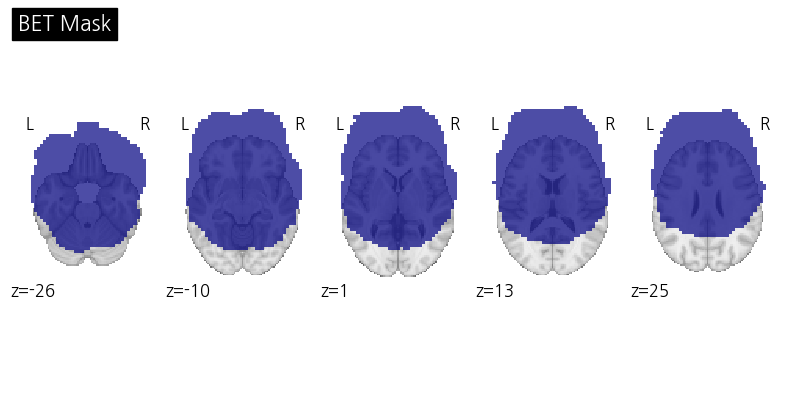

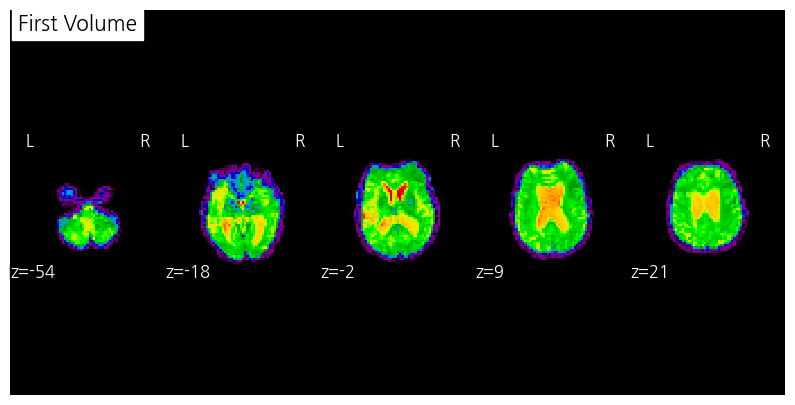

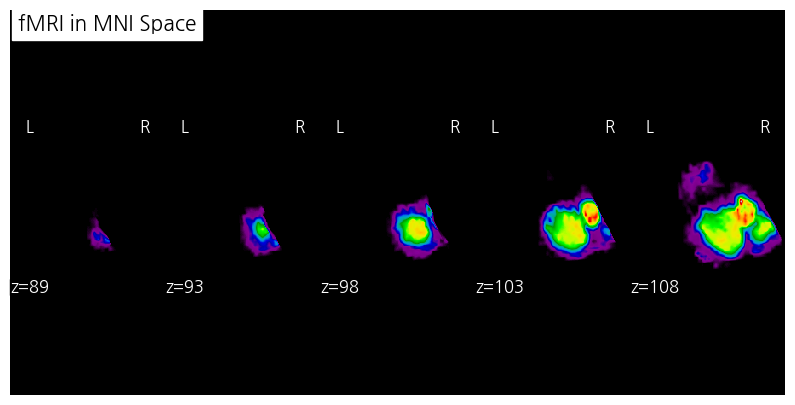

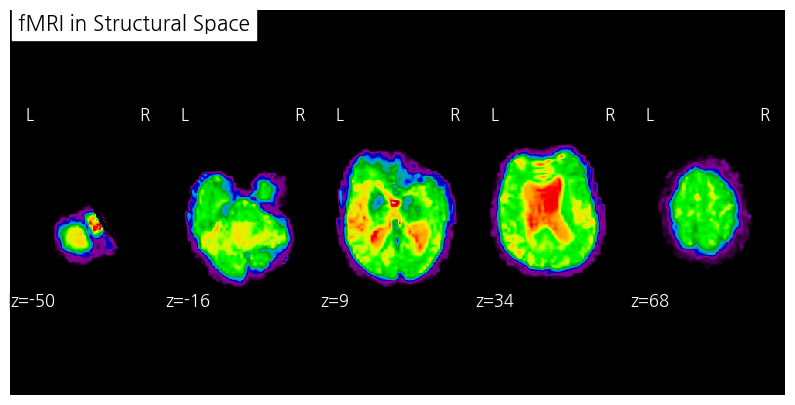

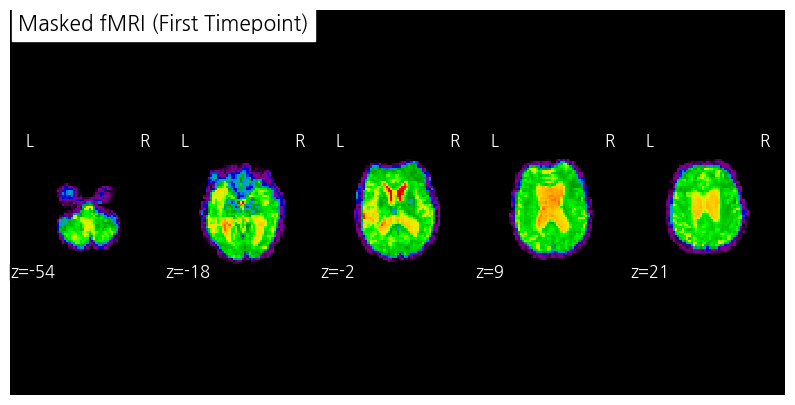

Visualization completed.


In [10]:
import os
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

result_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

bet_mask = os.path.join(result_dir, 'bet_output_mask.nii.gz')
first_volume = os.path.join(result_dir, 'first_volume.nii.gz')
func_to_mni = os.path.join(result_dir, 'func_to_mni.nii.gz')
func_to_struct = os.path.join(result_dir, 'func_to_struct.nii.gz')
masked_fmri = os.path.join(result_dir, 'masked_fmri.nii.gz')

# 1. BET 마스크 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_roi(bet_mask, display_mode='z', cut_coords=5, title="BET Mask", axes=ax)
plt.show()

# 2. 첫 번째 볼륨 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="First Volume", axes=ax)
plt.show()

# 3. MNI 공간으로 변환된 fMRI 데이터 시각화
func_to_mni_img = nib.load(func_to_mni)
if len(func_to_mni_img.shape) == 4:
    func_to_mni_data = func_to_mni_img.slicer[..., 0]
else:
    func_to_mni_data = func_to_mni_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_mni_data, display_mode='z', cut_coords=5, title="fMRI in MNI Space", axes=ax)
plt.show()

# 4. 구조적 공간으로 변환된 fMRI 데이터 시각화
func_to_struct_img = nib.load(func_to_struct)
if len(func_to_struct_img.shape) == 4:
    func_to_struct_data = func_to_struct_img.slicer[..., 0]
else:
    func_to_struct_data = func_to_struct_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(func_to_struct_data, display_mode='z', cut_coords=5, title="fMRI in Structural Space", axes=ax)
plt.show()

# 5. 마스킹된 fMRI 데이터 시각화 (첫 번째 시간점)
masked_fmri_img = nib.load(masked_fmri)
if len(masked_fmri_img.shape) == 4:
    masked_fmri_data = masked_fmri_img.slicer[..., 0]
else:
    masked_fmri_data = masked_fmri_img
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plotting.plot_epi(masked_fmri_data, display_mode='z', cut_coords=5, title="Masked fMRI (First Timepoint)", axes=ax)
plt.show()

print("Visualization completed.")

/tmp/ipykernel_1629406/60803391.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


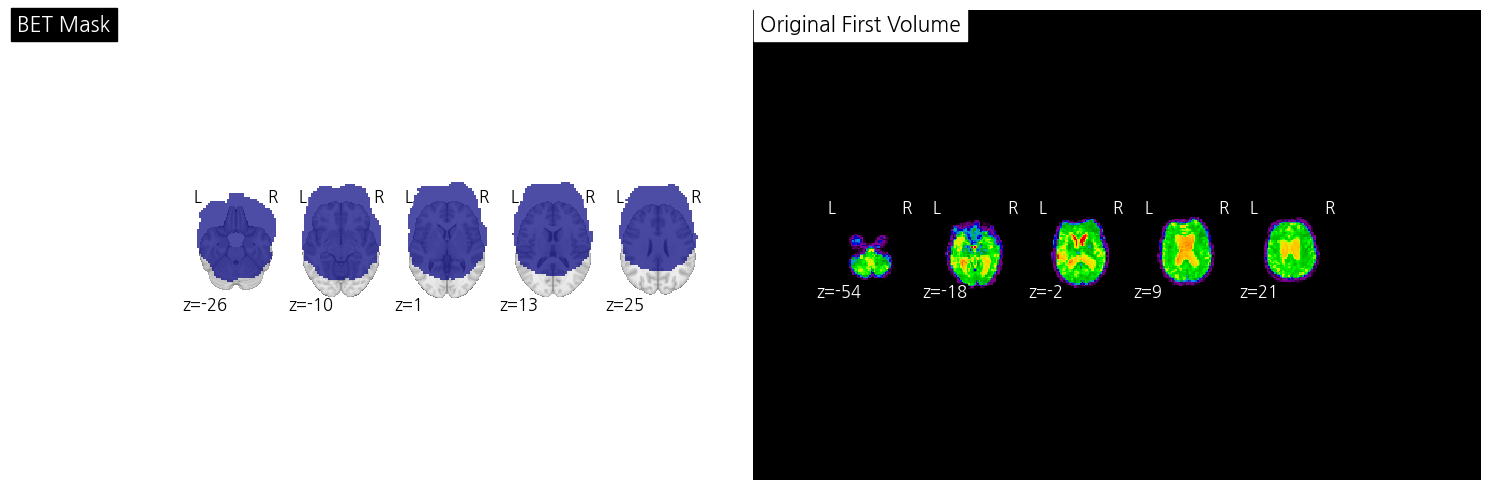

/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/nilearn/image/resampling.py:809: UserWarning: Casting data from int32 to float32
  return resample_img(
/tmp/ipykernel_1629406/60803391.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


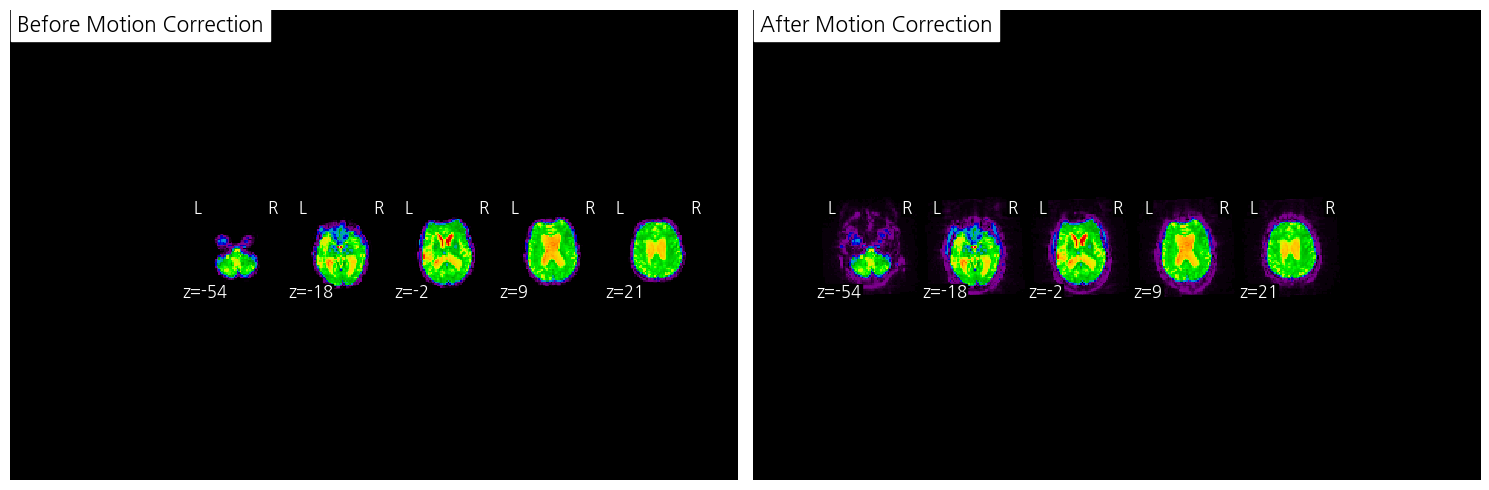

/tmp/ipykernel_1629406/60803391.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


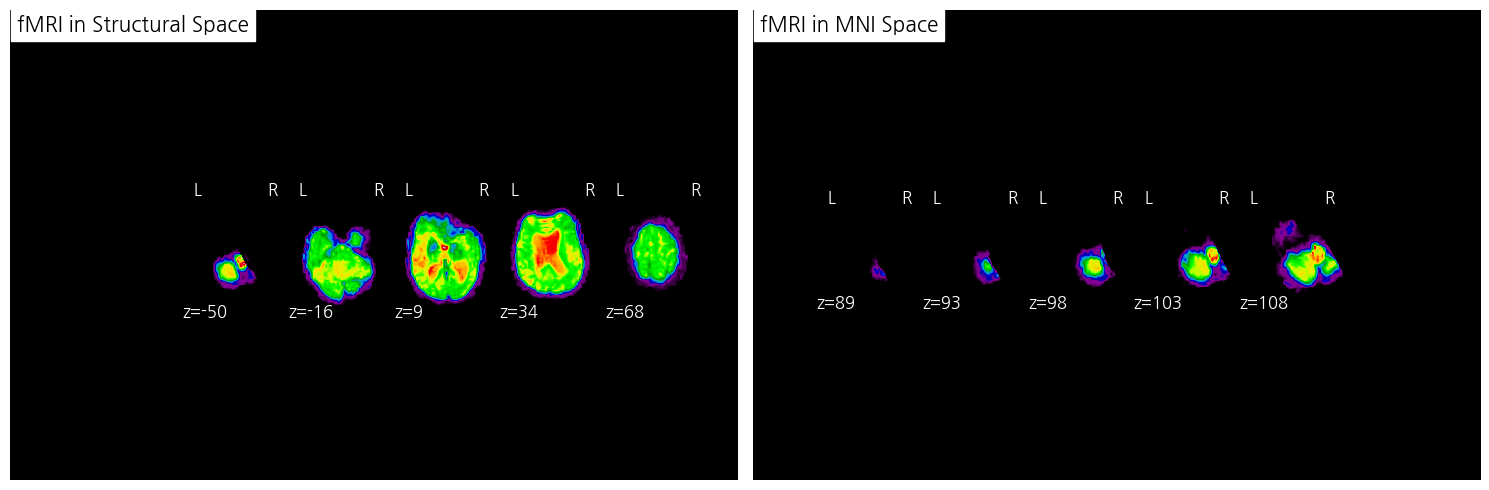

/tmp/ipykernel_1629406/60803391.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


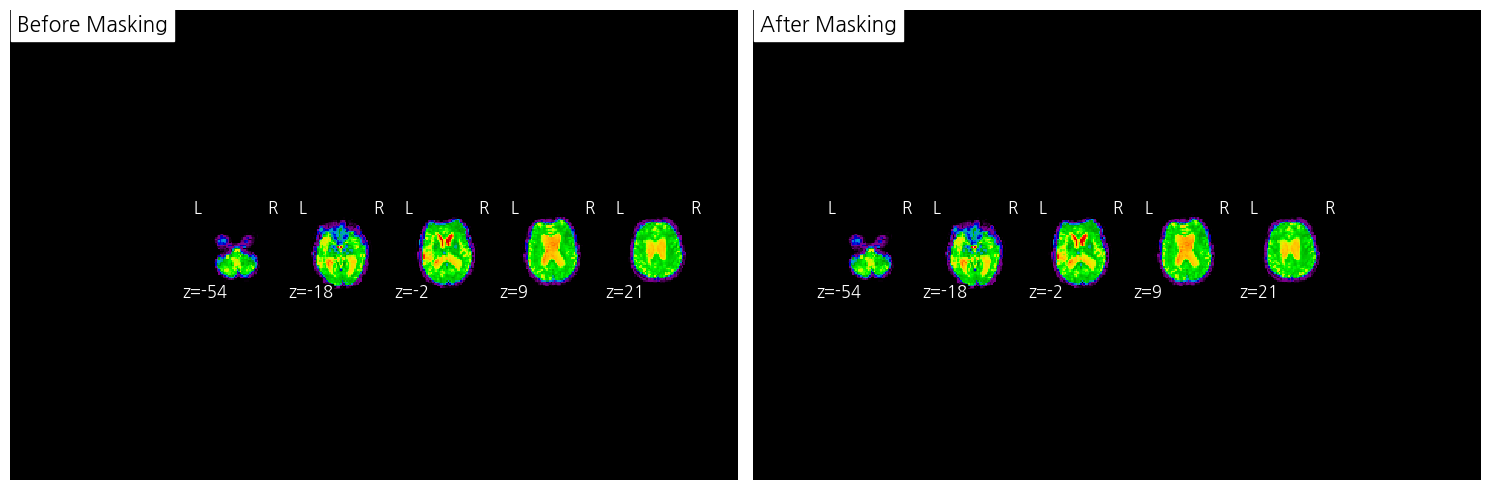

/tmp/ipykernel_1629406/60803391.py:66: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/minyoungxi/anaconda3/envs/TorchEnv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


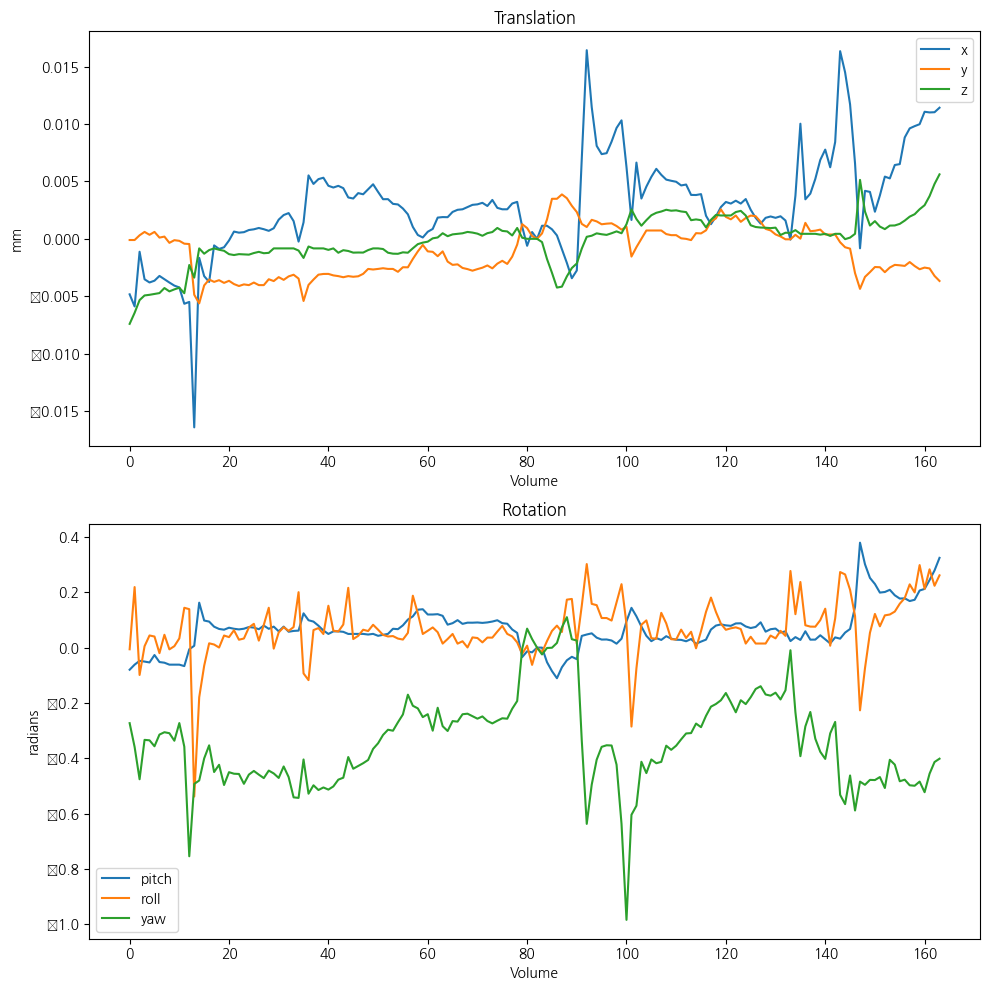

Visualization completed.


In [11]:
import os
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib
import numpy as np

result_dir = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/Sample'

bet_mask = os.path.join(result_dir, 'bet_output_mask.nii.gz')
first_volume = os.path.join(result_dir, 'first_volume.nii.gz')
func_to_mni = os.path.join(result_dir, 'func_to_mni.nii.gz')
func_to_struct = os.path.join(result_dir, 'func_to_struct.nii.gz')
masked_fmri = os.path.join(result_dir, 'masked_fmri.nii.gz')
mcflirt_output = os.path.join(result_dir, 'mcflirt_output.nii.gz')

# 함수: 4D 이미지에서 첫 번째 볼륨 추출
def get_first_volume(img_path):
    img = nib.load(img_path)
    if len(img.shape) == 4:
        return img.slicer[..., 0]
    return img

# 1. BET 마스크와 원본 fMRI 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plotting.plot_roi(bet_mask, display_mode='z', cut_coords=5, title="BET Mask", axes=axes[0])
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="Original First Volume", axes=axes[1])
plt.tight_layout()
plt.show()

# 2. 모션 보정 전후 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="Before Motion Correction", axes=axes[0])
plotting.plot_epi(get_first_volume(mcflirt_output), display_mode='z', cut_coords=5, title="After Motion Correction", axes=axes[1])
plt.tight_layout()
plt.show()

# 3. MNI 공간과 구조적 공간 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plotting.plot_epi(get_first_volume(func_to_struct), display_mode='z', cut_coords=5, title="fMRI in Structural Space", axes=axes[0])
plotting.plot_epi(get_first_volume(func_to_mni), display_mode='z', cut_coords=5, title="fMRI in MNI Space", axes=axes[1])
plt.tight_layout()
plt.show()

# 4. 마스킹 전후 비교
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plotting.plot_epi(first_volume, display_mode='z', cut_coords=5, title="Before Masking", axes=axes[0])
plotting.plot_epi(get_first_volume(masked_fmri), display_mode='z', cut_coords=5, title="After Masking", axes=axes[1])
plt.tight_layout()
plt.show()

# 5. 모션 파라미터 플롯
motion_params = np.loadtxt(os.path.join(result_dir, 'mcflirt_output.par'))
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
ax1.plot(motion_params[:, :3])
ax1.set_title('Translation')
ax1.set_xlabel('Volume')
ax1.set_ylabel('mm')
ax1.legend(['x', 'y', 'z'])

ax2.plot(motion_params[:, 3:])
ax2.set_title('Rotation')
ax2.set_xlabel('Volume')
ax2.set_ylabel('radians')
ax2.legend(['pitch', 'roll', 'yaw'])

plt.tight_layout()
plt.show()

print("Visualization completed.")

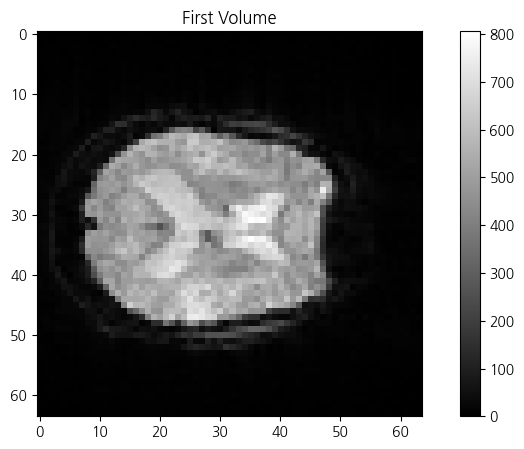

In [8]:
import nibabel as nib

fmri_file = '/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1/OAS30016_MR_d0021/func2/NIFTI/sub-OAS30016_ses-d0021_task-rest_run-02_bold.nii.gz'
img = nib.load(fmri_file)
data = img.get_fdata()

plt.figure(figsize=(10, 5))
plt.imshow(data[:, :, data.shape[2]//2, 0], cmap='gray')
plt.title("First Volume")
plt.colorbar()
plt.show()